In [1]:
import seaborn as sns
%matplotlib inline
import numpy as np 
import pandas as pd 
import os
import re
import matplotlib.pyplot as plt
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, GRU, LSTM, Bidirectional
from keras.layers.embeddings import Embedding
from keras.initializers import Constant
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

In [2]:
df=pd.read_json('sarcasm_detection_shared_task_twitter_training.jsonl',lines=True)

In [3]:
df.head()

,label,response,context
0,SARCASM,@USER @USER @USER I don't get this .. obviousl...,[A minor child deserves privacy and should be ...
1,SARCASM,@USER @USER trying to protest about . Talking ...,[@USER @USER Why is he a loser ? He's just a P...
2,SARCASM,@USER @USER @USER He makes an insane about of ...,[Donald J . Trump is guilty as charged . The e...
3,SARCASM,@USER @USER Meanwhile Trump won't even release...,[Jamie Raskin tanked Doug Collins . Collins lo...
4,SARCASM,@USER @USER Pretty Sure the Anti-Lincoln Crowd...,[Man ... y ’ all gone “ both sides ” the apoca...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   label     5000 non-null   object
 1   response  5000 non-null   object
 2   context   5000 non-null   object
dtypes: object(3)
memory usage: 117.3+ KB


In [5]:
df['label'].value_counts()

NOT_SARCASM    2500
SARCASM        2500
Name: label, dtype: int64

<AxesSubplot:xlabel='label', ylabel='count'>

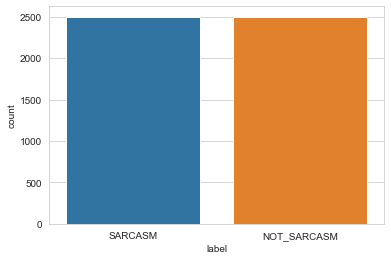

In [6]:
sns.set_style('whitegrid')
sns.countplot(x='label',data=df)

In [7]:
df['response']=df['response'].str.replace('@USER', "") 
df['response']=df['response'].str.replace('\d+', '')
df['response']=df['response'].str.lower()
df['response']=df['response'].str.replace('[^\w\s]','')

df['context']=df['context'].apply(lambda x: ','.join(map(str, x)))
df['context']=df['context'].str.replace('@USER', "") 
df['context']=df['context'].str.lower()
df['context']=df['context'].str.replace('[^\w\s]','')
df['context']=df['context'].str.replace('\d+', '')

df.head()

<ipython-input-7-c9cae9c58653>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['response']=df['response'].str.replace('\d+', '')
<ipython-input-7-c9cae9c58653>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df['response']=df['response'].str.replace('[^\w\s]','')
<ipython-input-7-c9cae9c58653>:9: FutureWarning: The default value of regex will change from True to False in a future version.
  df['context']=df['context'].str.replace('[^\w\s]','')
<ipython-input-7-c9cae9c58653>:10: FutureWarning: The default value of regex will change from True to False in a future version.
  df['context']=df['context'].str.replace('\d+', '')


,label,response,context
0,SARCASM,i dont get this obviously you do care or y...,a minor child deserves privacy and should be k...
1,SARCASM,trying to protest about talking about him a...,why is he a loser hes just a press secretar...
2,SARCASM,he makes an insane about of money from the ...,donald j trump is guilty as charged the evid...
3,SARCASM,meanwhile trump wont even release his sat sc...,jamie raskin tanked doug collins collins look...
4,SARCASM,pretty sure the antilincoln crowd claimed th...,man y all gone both sides the apocalypse o...


In [8]:
X=df['response'].values
y=df['label'].values

In [9]:
y = pd.get_dummies(df['label'])
y = y.iloc[:,1].values
y

array([1, 1, 1, ..., 0, 0, 0], dtype=uint8)

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [11]:
vocab_size=10000
embedding_dim=16
max_length=32
trunc_type='post'
padding_type='post'
oov_tok='<oov>'

In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer= Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

word_index=tokenizer.word_index

training_sequences=tokenizer.texts_to_sequences(X_train)
training_padded=pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences=tokenizer.texts_to_sequences(X_test)
testing_padded=pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [13]:
training_padded

array([[  89, 3205,   22, ...,    0,    0,    0],
       [  26, 2422,    8, ...,    0,    0,    0],
       [   2, 4930,  209, ...,    0,    0,    0],
       ...,
       [ 529,  246,   84, ...,    0,    0,    0],
       [  25,  315,    9, ...,    0,    0,    0],
       [ 984,   19,   84, ...,    0,    0,    0]], dtype=int32)

In [14]:
print(training_padded.shape)
print(testing_padded.shape) 
print(y_train.shape)
print(y_test.shape)

(4000, 32)
(1000, 32)
(4000,)
(1000,)


In [16]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2021-07-05 21:07:26--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-07-05 21:07:27--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-07-05 21:07:29--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [17]:
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [18]:
%ls

SARCASM detection using Glove.ipynb
Sarcasm_Detection_using_CNN_twitter_dataset_BERT.ipynb
Sarcasm_Detection_using_CNN_twitter_dataset_v1.ipynb
Sarcasm_Detection_with_Basic_NN_Headlines_dataset_v1.ipynb
Sarcasm_Detection_with_Basic_NN_twitter_dataset_r_v1.ipynb
Sarcasm_Detection_with_Neural_Networks_twitter_dataset_v1.ipynb
Sarcasm_Glove_twitter_dataset.ipynb
Sarcasm_Headlines_Dataset.json
Untitled5.ipynb
glove.6B.100d.txt
glove.6B.200d.txt
glove.6B.300d.txt
glove.6B.50d.txt
glove.6B.zip
sarcasm_detection_shared_task_twitter_training.jsonl
using_ML_Algos.ipynb
using_ML_Algos2.ipynb


In [20]:
embeddings_index = {}
embedding_dim = 100
f = open("glove.6B.100d.txt", encoding = "utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [21]:
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
c = 0
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        c+=1
        embedding_matrix[i] = embedding_vector
print(c)

9716


In [22]:
embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)

In [23]:
model = Sequential()
model.add(embedding_layer)
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.25))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

print('Summary of the built model...')
print(model.summary())

Summary of the built model...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 32, 100)           1126800   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                42240     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 1,169,105
Trainable params: 42,305
Non-trainable params: 1,126,800
_________________________________________________________________
None


In [24]:
history = model.fit(training_padded, y_train, batch_size=32, epochs=25, validation_data=(testing_padded, y_test), verbose=2)

Epoch 1/25
125/125 - 24s - loss: 0.6429 - acc: 0.6248 - val_loss: 0.5849 - val_acc: 0.6930
Epoch 2/25
125/125 - 1s - loss: 0.5613 - acc: 0.7105 - val_loss: 0.5578 - val_acc: 0.7050
Epoch 3/25
125/125 - 1s - loss: 0.5521 - acc: 0.7138 - val_loss: 0.5495 - val_acc: 0.7100
Epoch 4/25
125/125 - 1s - loss: 0.5306 - acc: 0.7325 - val_loss: 0.5500 - val_acc: 0.7060
Epoch 5/25
125/125 - 1s - loss: 0.5284 - acc: 0.7372 - val_loss: 0.5460 - val_acc: 0.7130
Epoch 6/25
125/125 - 1s - loss: 0.5127 - acc: 0.7490 - val_loss: 0.5344 - val_acc: 0.7090
Epoch 7/25
125/125 - 1s - loss: 0.5016 - acc: 0.7552 - val_loss: 0.5599 - val_acc: 0.6850
Epoch 8/25
125/125 - 1s - loss: 0.4971 - acc: 0.7513 - val_loss: 0.5434 - val_acc: 0.7140
Epoch 9/25
125/125 - 1s - loss: 0.4848 - acc: 0.7650 - val_loss: 0.5696 - val_acc: 0.7030
Epoch 10/25
125/125 - 1s - loss: 0.4659 - acc: 0.7805 - val_loss: 0.5795 - val_acc: 0.6870
Epoch 11/25
125/125 - 1s - loss: 0.4498 - acc: 0.7885 - val_loss: 0.5505 - val_acc: 0.7030
Epoch 1

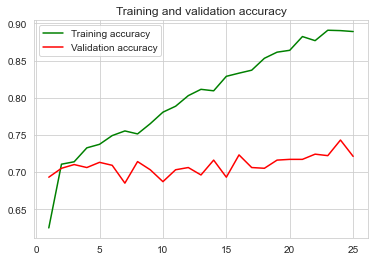

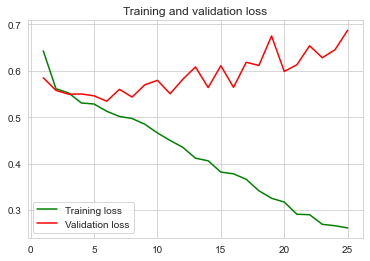

In [25]:
# Plot results
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [31]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
def CleanTokenize(df):
    head_lines = list()
    lines = df["headline"].values.tolist()

    for line in lines:
        line = clean_text(line)
        # tokenize the text
        tokens = word_tokenize(line)
        # remove puntuations
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens]
        # remove non alphabetic characters
        words = [word for word in stripped if word.isalpha()]
        stop_words = set(stopwords.words("english"))
        # remove stop words
        words = [w for w in words if not w in stop_words]
        head_lines.append(words)
    return head_lines
def clean_text(text):
    text = text.lower()
    
    pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    text = pattern.sub('', text)
    text = " ".join(filter(lambda x:x[0]!='@', text.split()))
    emoji = re.compile("["
                           u"\U0001F600-\U0001FFFF"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    text = emoji.sub(r'', text)
    text = text.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"that's", "that is", text)        
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"where's", "where is", text) 
    text = re.sub(r"\'ll", " will", text)  
    text = re.sub(r"\'ve", " have", text)  
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"did't", "did not", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"have't", "have not", text)
    text = re.sub(r"[,.\"\'!@#$%^&*(){}?/;`~:<>+=-]", "", text)
    return text
def predict_sarcasm(s):
    x_final = pd.DataFrame({"headline":[s]})
    test_lines = CleanTokenize(x_final)
    test_sequences = tokenizer_obj.texts_to_sequences(test_lines)
    test_review_pad = pad_sequences(test_sequences, maxlen=max_length, padding='post')
    pred = model.predict(test_review_pad)
    pred*=100
    if pred[0][0]>=50: return "It's a sarcasm!" 
    else: return "It's not a sarcasm."
    
predict_sarcasm("You just broke my car window. Great job.")

[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1123)>
[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1123)>


LookupError: 
**********************************************************************
  Resource [93mpunkt[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt/PY3/english.pickle[0m

  Searched in:
    - '/Users/arnavsudan/nltk_data'
    - '/Library/Frameworks/Python.framework/Versions/3.9/nltk_data'
    - '/Library/Frameworks/Python.framework/Versions/3.9/share/nltk_data'
    - '/Library/Frameworks/Python.framework/Versions/3.9/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
    - ''
**********************************************************************
